# Modele liniowe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Na początek ustawimy globalnie opcję `set_output` ze Scikit-learn'a ([dokumentacja](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html)). Dzięki temu transformowane dane będą zawsze na wyjściu typu `pd.DataFrame`, zamiast `np.ndarray`, i zachowają odpowiednie nazwy cech.

In [2]:
import sklearn

sklearn.set_config(transform_output="pandas")

## Przewidywanie cen domów

Wykorzystamy zbiór danych [Ames housing](https://www.openintro.org/book/statdata/?data=ames), w którym zadaniem jest przewidywanie wartości domu na podstawie cech budynku, działki, lokalizacji itp. Jest to więc przewidywanie wartości ciągłej, czyli regresja. Obejmuje zmienne do usunięcia (np. ID transakcji), numeryczne (floaty i inty), kategoryczne nieuporządkowane (*categorical nominal*) oraz kategoryczne uporządkowane (*categorical ordinal*), więc będzie wymagał wstępnego przetworzenia tak jak większość prawdziwych danych w ML.

Inne znane, ale gorsze jakościowo zbiory tego typu to na przykład:
- Boston housing - rasistowski, z tego powodu usunięty np. ze Scikit-learn ([wyjaśnienie](https://fairlearn.org/main/user_guide/datasets/boston_housing_data.html), [dyskusja](https://github.com/quantumblacklabs/causalnex/issues/92), [badanie](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8))
- California housing - zbyt prosty (tylko kilka zmiennych numerycznych), użyty np. w książce "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" A. Geron ([opis](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html))

Autor zbioru to Dean De Cock, a zbiór został opisany oryginalnie w [tym artykule](https://jse.amstat.org/v19n3/decock.pdf). Szczegółowe opisy zmiennych znajdują się w pliku `ames_description.txt`.

Formatem pliku jest **Apache Parquet**, bardzo wydajny format binarny. Ma on szereg zalet w ML i inżynierii danych porównaniu do plików CSV:
- zapisuje informacje o typie kolumn
- jednoznaczna specyfikacja (np. brak problemów z typem separatora, jak w CSV)
- kompresja liczb, napisów etc. w oparciu o ich typ
- znacznie mniejszy rozmiar plików, zwykle kilka razy
- dużo większa szybkość zapisu i odczytu

Dla zainteresowanych szczegółami: [link 1](https://www.databricks.com/glossary/what-is-parquet#:~:text=Apache%20Parquet%20is%20an%20open,handle%20complex%20data%20in%20bulk.), [link 2](https://data-mozart.com/parquet-file-format-everything-you-need-to-know/), [link 3](https://learncsdesigns.medium.com/understanding-apache-parquet-d722645cfe74). Ten format ma szerokie wsparcie, w tym w Pandasie. W przypadku tego zbioru, CSV zajmuje ~1.2 MB, a Parquet ~0.2 MB.

In [3]:
df = pd.read_parquet("ames_data.parquet")

# remove dots from names to match data_description.txt
df.columns = [col.replace(".", "") for col in df.columns]

df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,None,IR1,Lvl,...,0,None,None,None,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,None,Reg,Lvl,...,0,None,MnPrv,None,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,None,IR1,Lvl,...,0,None,None,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,None,Reg,Lvl,...,0,None,None,None,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,None,IR1,Lvl,...,0,None,MnPrv,None,0,3,2010,WD,Normal,189900


In [4]:
df.shape

(2930, 82)

## Eksploracja danych, czyszczenie danych i inżynieria cech

Wstępne czyszczenie danych (*data cleaning*) obejmuje:
- usunięcie kolumn `Order` oraz `PID`
- usunięcie obserwacji odstających (*outliers*), które mają powyżej 4000 stóp kwadratowych (ok. 370 metrów kwadratowych) powierzchni
- usunięcie wpisów z dzielnic `GrnHill` oraz `Landmrk`, które obejmują w sumie zaledwie 3 domy
- transformacja logarytmiczna zmiennej zależnej (ceny domu)

To drugie jest motywowane wykresem przedstawionym poniżej. Zostało uznane za błąd już przez samego autora.

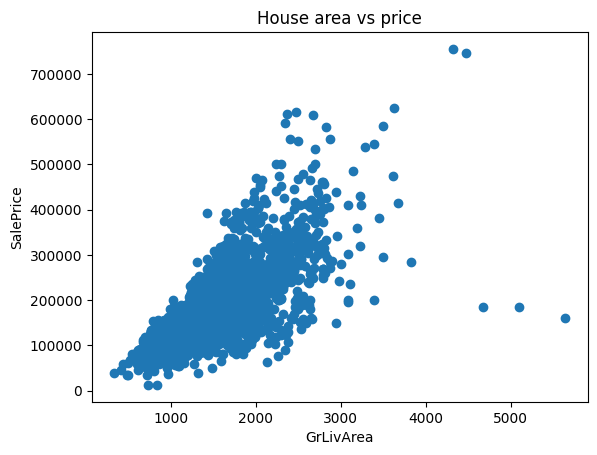

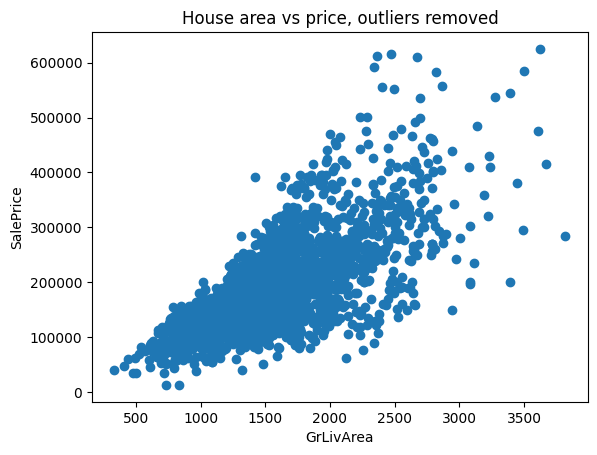

In [5]:
df = df.drop(["Order", "PID"], axis="columns")
df = df.loc[~df["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

df = df.loc[df["GrLivArea"] <= 4000, :]

plt.scatter(df["GrLivArea"], df["SalePrice"])
plt.title("House area vs price, outliers removed")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

Zawsze warto też przyjrzeć się rozkładowi zmiennej docelowej, żeby poznać jego typ i skalę. Jak widać poniżej, rozkład jest dość skośny, co ma sens - mało jest bardzo drogich domów. Można to zatem uznać za problem **regresji niezbalansowanej (imbalanced regression)**, w którym rozkład zmiennej docelowej nie jest normalny.

Załóżmy, że typowego klienta nie interesują bardzo drogie domy. Cały ciężki ogon rozkładu można zatem uznać zasadniczo za outliery - im większa wartość, tym mniej interesuje przeciętną osobę. Warto też pamiętać, że realny "przeciętny" dochód to mediana, a nie średnia zarobków, co odpowiednio przekłada się na zainteresowanie domami.

W tym przypadku warto przetransformować tę zmienną logarytmem bliżej rozkładu normalnego z dwóch powodów.

Po pierwsze, stabilność numeryczna - wartości są bardzo duże, rzędu setek tysięcy, i przy obliczaniu odchylenia standardowego czy wariancji to byłby problem. Logarytm to przykład **transformacji stabilizującej wariancję (variance-stabilizing transform)**.

Ponadto regresja liniowa (pierwszy model liniowy, który będziemy rozważać) czyni szereg założeń w modelowaniu, co wynika z jej podstaw statystycznych. Są to między innymi:
1. **Normalność błędów (residuals normality)** - błędy modelu, czyli $y - \hat{y}$, mają rozkład normalny
2. **Homoskedastyczność (homoscedasticity)** - błędy mają stałą wariancję, czyli nie zależą od wielkości zmiennej zależnej

W naszym przypadku oznacza to, że podobnie często nie doceniamy albo przeceniamy wartość domu, oraz dla tanich i drogich domów mamy podobny błąd. Przy rozkładzie zmiennej zależnej bardzo różnym od normalnego te założenia są typowo łamane, co skutkuje gorszą jakością predykcji modelu. Dlatego transformacji warto też dokonać dla lepszej jakości modelu.

Skąd wiemy, że logarytm? Bo rozkłady o dodaniej skośności (positively skewed) przesuwa się "w prawo" właśnie logarytmem, a w drugą stronę eksponentą. Dla zainteresowanych: [link 1](https://www.biostathandbook.com/transformation.html), [link 2](https://bookdown.org/dereksonderegger/571/8-LogTransformations-Chapter.html). Są też algorytmy, które potrafią same estymować potrzebną transformację, np. **Box-Cox transform** albo **Yeo-Johnson transform**. Podobne transformacje można też oczywiście wykonywać nie tylko dla zmiennej zależnej, ale też (a nawet jest to częstsze) dla cech.

**Zadanie 1 (1 punkt)**

1. Narysuj wykres cen - histogram kolumny `"SalePrice"`. Pamiętaj o podaniu tytułu i dodaniu legendy.
2. Oblicz średnią i medianę cen, a następnie nanieś je na wykres jako pionowe, przerywane linie. Może się przydać [ten przykład](https://stackoverflow.com/a/57046310/9472066). Wypisz te wartości, lub zawrzyj je w opisie w legendzie, zaokrąglone do liczb całkowitych.
3. Zlogarytmuj ceny z pomocą `np.log1p` (zamień istniejące wartości).
4. Narysuj wykres po zlogarytmowaniu, razem z liniami dla średniej i mediany.

Może ci się przydać metoda `.plot.hist()` dla `pd.Series`. Zwraca ona normalny wykres Matplotliba, do którego można potem dodawać kolejne elementy.

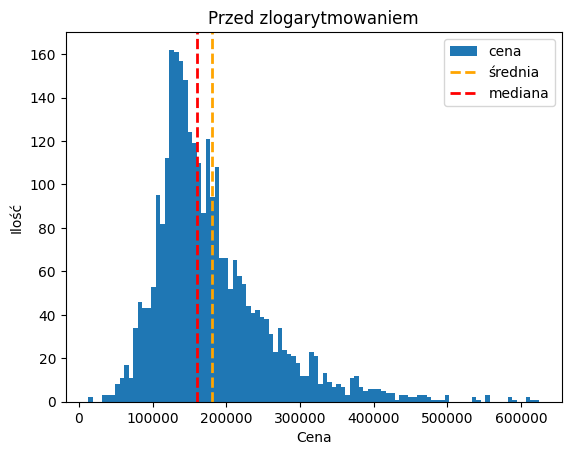

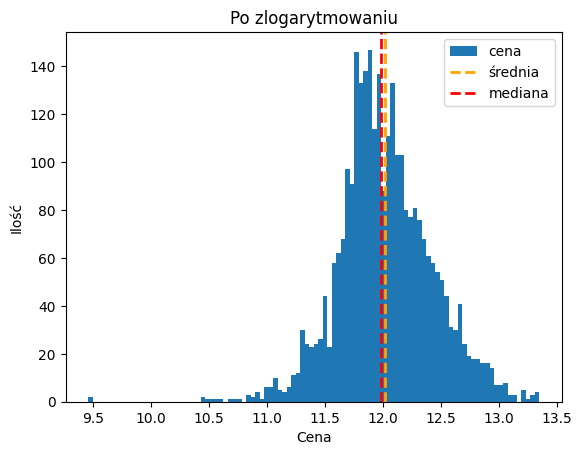

In [6]:
df["SalePrice"].plot.hist(bins=100)
plt.axvline(df["SalePrice"].mean(), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(df["SalePrice"].median(), color='red', linestyle='dashed', linewidth=2)
plt.title("Przed zlogarytmowaniem")
plt.legend(["cena", "średnia", "mediana"])
plt.xlabel("Cena")
plt.ylabel("Ilość")
plt.show()

df["SalePrice"] = np.log1p(df["SalePrice"])
df["SalePrice"].plot.hist(bins=100)
plt.axvline(df["SalePrice"].mean(), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(df["SalePrice"].median(), color='red', linestyle='dashed', linewidth=2)
plt.title("Po zlogarytmowaniu")
plt.legend(["cena", "średnia", "mediana"])
plt.xlabel("Cena")
plt.ylabel("Ilość")
plt.show()

W zbiorze znajdują się liczne wartości brakujące, które zostały uzupełnione na podstawie [tego notebooka na Kaggle](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset).

In [7]:
def replace_na(df: pd.DataFrame, col: str, value) -> None:
    df.loc[:, col] = df.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df, "BsmtQual", value="No")
replace_na(df, "BsmtCond", value="No")
replace_na(df, "BsmtExposure", value="No")
replace_na(df, "BsmtFinType1", value="No")
replace_na(df, "BsmtFinType2", value="No")
replace_na(df, "BsmtFullBath", value=0)
replace_na(df, "BsmtHalfBath", value=0)
replace_na(df, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df, "Condition1", value="Norm")
replace_na(df, "Condition2", value="Norm")

# External stuff : NA most likely means average
replace_na(df, "ExterCond", value="TA")
replace_na(df, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df, "GarageType", value="No")
replace_na(df, "GarageFinish", value="No")
replace_na(df, "GarageQual", value="No")
replace_na(df, "GarageCond", value="No")
replace_na(df, "GarageArea", value=0)
replace_na(df, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df, "MasVnrType", value="None")
replace_na(df, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df, "MiscFeature", value="No")
replace_na(df, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df, "PoolQC", value="No")
replace_na(df, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df, "FireplaceQu", value="No")
replace_na(df, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df, "SaleCondition", value="Normal")

# Electrical : NA most likely means standard circuit & breakers
replace_na(df, "Electrical", value="SBrkr")

W dalszej kolejności zamienimy zmienne `MSSubClass` i `MoSold` z numerycznych na kategoryczne, zgodnie z ich znaczeniem. Zakodujemy także zmienne kategoryczne uporządkowane (categorical ordinal) z tekstowych na kolejne liczby całkowite.

In [8]:
df = df.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

In [9]:
df = df.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

C:\Users\jdyde\AppData\Local\Temp\ipykernel_17488\3839597250.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


W Pandasie zmienne kategoryczne, napisy itp. są typu `object`, natomiast numeryczne mają typy z Numpy'a, np. `int64`. Oczywiście oba rodzaje zmiennych trzeba przetwarzać na inne sposoby, więc zapiszemy to od razu. Wyodrębnimy też wektor docelowy.

Od razu dokonamy też podziału na zbiór treningowy i testowy. Jako że nasz zbiór jest dość mały, to podział będzie 70%-30%.

In [10]:
from sklearn.model_selection import train_test_split

y = df.pop("SalePrice")

categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=0
)

## Analiza i przetwarzanie cech

Modele liniowe działają najlepiej, kiedy nasze cechy są odpowiednio przetworzone:
- nie może być wartości brakujących
- wszystkie zmienne mają podobny zakres wartości
- nie ma mocno skorelowanych ze sobą cech
- zmienne kategoryczne muszą być zakodowane, przy czym dobrze jest, kiedy cech nie jest zbyt dużo

Na start imputujemy wartości brakujące w zmiennych numerycznych i przeskalujemy je do zakresu $[0, 1]$. Potem dokonamy analizy, czy mamy mocno skorelowane zmienne.

Przy przetwarzaniu danych krok po kroku lepiej robić nowe zmienne, żeby dało się odpalić znowu komórkę notebooka. Przy reużywaniu zmiennych mogłaby nastąpić konieczność uruchomienia wszystkiego od początku. Może ci się to przydać w zadaniach.

Pamiętaj, żeby we wszystkich kolejnych zadaniach zastosować taką samą transformację na zbiorze treningowym i testowym. Wszelkie wartości estymujemy na zbiorze treningowym.

**Zadanie 2 (0.5 punktu)**

Wybierz same zmienne numeryczne. Dokonaj imputacji wartości brakujących medianą, oraz przeskaluj wartości do zakresu $[0, 1]$. Przydatne klasy: `ColumnTransformer`, `Pipeline`, `SimpleImputer`, `MinMaxScaler`.

Domyślnie `ColumnTransformer` dopisuje do nazw cech wyjściowych nazwę transformera jako prefix. Bywa to dość nieczytelne i problematyczne w dalszym przetwarzaniu danych. Żeby to wyłączyć, przekaż opcję `verbose_feature_names_out=False`.

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

ct = ColumnTransformer([('pipeline', num_pipeline, numerical_features)], verbose_feature_names_out=False)
X_train1 = ct.fit_transform(X_train_raw)
X_test1 = ct.transform(X_test_raw)

Sprawdźmy teraz, czy mamy mocno skorelowane zmienne. Typowo przyjmuje się wartość bezwzględną korelacji powyżej progu 0.8/0.9/0.95. Pierwszą weryfikację można zrobić "na oko" na podstawie wykresu typu heatmap. Przekątną oczywiście ignorujemy - każda cecha ma korelację 1.0 z samą sobą.

Jeżeli zauważymy grupy skorelowanych cech, to z każdej grupy trzeba zostawić jedną cechę. Biblioteka Feature-engine, komplatybilna ze Scikie-learn, oferuje tutaj wygodną klasę `SmartCorrelatedSelection`, która pozwala z każdej grupy cech zostawić tę o największej wariancji.

Czemu o największej wariancji? Bo taka cecha jest mocno zmienna, a więc niesie jakąś informację. Cechy o bardzo niskiej wariancji praktycznie się nie zmieniają, więc prawdopodobnie nie są zbyt informatywne.

**Zadanie 3 (0.5 punktu)**

Oblicz korelacje między cechami w zbiorze treningowym, oraz narysuj heatmapę korelacji. Pandas potrafi obliczyć korelacje, a Seaborn - narysować wygodnie heatmapę.

Następnie wykorzystaj Feature-engine do eliminacji mocno skorelowanych cech, z progiem 0.8 (mamy sporo cech, więc eliminujmy, czemu nie), pozostawiając cechy o największej wariancji. Wypisz nazwy wyeliminowanych cech.

['Fireplaces',
 'GarageArea',
 'BsmtFinSF2',
 'TotRmsAbvGrd',
 'GarageCond',
 'PoolQC']

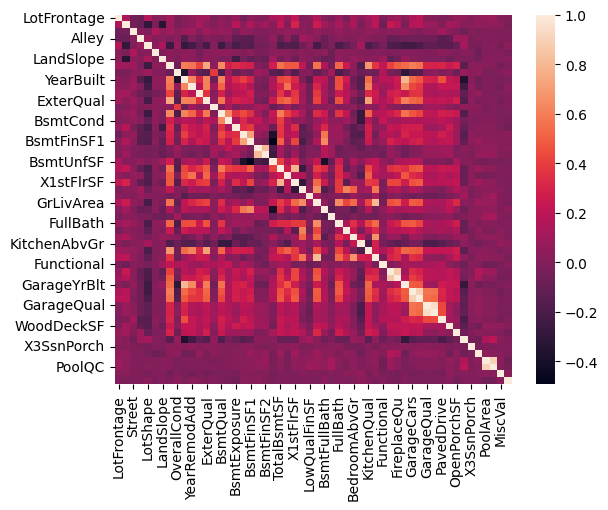

In [12]:
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection

sns.heatmap(X_train1.corr())

tr = SmartCorrelatedSelection(
    threshold=0.8,
    selection_method="variance")

X_train2 = tr.fit_transform(X_train1)
X_test2 = tr.transform(X_test1)

tr.features_to_drop_

Przejdźmy teraz do zmiennych kategorycznych. Jeżeli pewne kategorie występują bardzo rzadko, to prawdopodobnie nie ma sensu ich rozróżniać, i można by je połączyć w jedną, np. "Other" albo "Rare". Eliminacja rzadkich kategorii bardzo zmniejszy wymiarowość po one-hot encodingu, redukując złożoność obliczeniową i pamięciową. Często robi się to nawet głównie z tego powodu, nawet jeżeli lekko pogorszy to wyniki (aczkolwiek często daje nieco lepsze).

Po tym kroku możemy już wykonać one-hot encoding i uzyskać nasze zmienne kategoryczne.

**Zadanie 4 (0.5 punktu)**

Stwórz `ColumnTransformer`, wykonujący w pipeline'ie dla zmiennych kategorycznych (analogicznie jak w zadaniu 1 dla zmiennych numerycznych):
- łączenie rzadkich kategorii (występujących w mniej niż 1% wierszy) w kategorię "Rare"
- one-hot encoding

Dla uniknięcia dummy variable trap, oraz zmniejszenia liczby wynikowych cech, podaj `drop="first"` w one-hot encodingu.

Przyda się `RareLabelEncoder` z Feature-engine. Żeby zadziałał dla każdej cechy, podaj mu `n_categories=0`.

In [13]:
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('rle', RareLabelEncoder(n_categories=0, tol=0.01)),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

ct_cat = ColumnTransformer([('pipeline', cat_pipeline, categorical_features)], verbose_feature_names_out=False)
X_train3 = ct_cat.fit_transform(X_train_raw)
X_test3 = ct_cat.transform(X_test_raw)

Teraz nasze cechy są w pełni przeprocesowane i gotowe do obliczeń. Trzeba je tylko połączyć - zmodyfikuj kod poniżej w zależności od nazw twoich zmiennych.

In [14]:
X_train_num = X_train2
X_test_num = X_test2

X_train_cat = X_train3
X_test_cat = X_test3

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [15]:
X_train.shape

(2045, 175)

## Regresja liniowa, ridge i LASSO

Naszym baseline'owym modelem liniowym, do którego będziemy odnosić bardziej złożone modele, będzie zwykła **regresja liniowa (linear regression)**

Naszymi metrykami będą zarówno **pierwiastek błędu średniokwadratowego (root mean squared error, RMSE)**, jak i **średni błąd bezwzględny (mean absolute error)**. Oba są w tej samej jednostce, co oryginalna zmienna zależna, ale skupiają się na innych rzeczach:
- RMSE bardziej uwzględni predykcje w ogonie, czyli drogie domy
- MAE bardziej skupi się na przeciętnym przypadku, czyli cenach bliżej mediany

W praktyce często interesuje nas kilka metryk, a mamy dużo modeli do sprawdzanie. Żeby nie kopiować kodu, warto zrobić funkcję, obliczającą i wypisującą metryki dla danego problemu. Dodatkowo tutaj musimy odwrócić logarytm, który zastosowaliśmy na początku, i takie odwrotne przekształcenia też dobrze jest zawrzeć w takiej funkcji.

In [16]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


def evaluate_model(
    y_train: np.ndarray,
    y_test: np.ndarray,
    y_pred_train: np.ndarray,
    y_pred_test: np.ndarray,
) -> None:
    y_train = np.expm1(y_train)
    y_test = np.expm1(y_test)

    y_pred_train = np.expm1(y_pred_train)
    y_pred_test = np.expm1(y_pred_test)

    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)

    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    print(f"Train RMSE {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  RMSE {rmse_test:.2f}, MAE: {mae_test:.2f}")

Jesteśmy teraz gotowi na trening naszych modeli. Na start wytrenujmy zwykłą regresję liniową.

In [17]:
from sklearn.linear_model import LinearRegression

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

y_pred_train = reg_linear.predict(X_train)
y_pred_test = reg_linear.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train, y_pred_test)

Train RMSE 17643.38, MAE: 12163.00
Test  RMSE 18695.21, MAE: 13107.66


Całkiem nieźle. Dla porównania, bez usuwania skorelowanych cech i grupowania rzadkich cech, RMSE na zbiorze testowym to ponad 21 tysięcy, a model wyraźnie przeucza. Warto wykonywać odpowiedni preprocessing danych!

Mamy tu wyraźną różnicę między RMSE i MAE. Można się temu przyjrzeć i przeanalizować rozkład **rezyduów (residuals)**, czyli błędów $y - \hat{y}$.

**Zadanie 5 (0.5 punktu)**

Narysuj rozkład błędów popełnianych przez model regresji liniowej. Pamiętaj o odwróceniu logarytmu eksponentą (`np.expm1`). Dobierz liczbę binów histogramu tak, żeby wykres był odpowiednio czytelny. Zaznacz liniami pionowymi średnią oraz medianę. Pamiętaj o opisaniu osi Y, legendzie i tytule.

Skomentuj rozkład. Jest symetryczny? Może częściej nie doceniamy wartości domu, albo ją przeceniamy, albo może są tu jakiejś pojedyncze outliery? Czy na podstawie tych rezyduów można wytłumaczyć różnicę między MAE i RMSE?

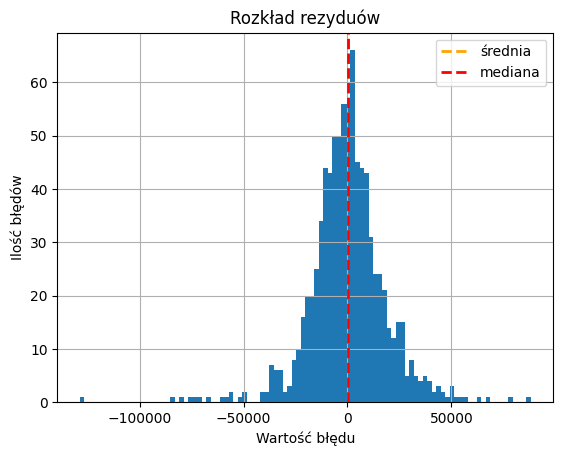

In [18]:
errors = np.expm1(y_test) - np.expm1(y_pred_test)
errors.hist(bins=100)
plt.axvline(errors.mean(), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(errors.median(), color='red', linestyle='dashed', linewidth=2)
plt.title("Rozkład rezyduów")
plt.legend(["średnia", "mediana"])
plt.xlabel("Wartość błędu")
plt.ylabel("Ilość błędów")
plt.show()

Rozkład jest symetryczny, średnia wyraźnie pokrywa się z medianą. Przez to, że występują outliery, które powodują w pewnych przypadkach bardzo dużą wartość błędu, RMSE jest większe niż MAE.

Mamy pewien overfitting - co prawda niewielki, ale zawsze jest coś do wyeliminowania. Dodatkowo mamy aż 175 cech - jeżeli niektóre z nich mają bardzo niską moc predykcyjną, to redukcja ich wag (lub ich usunięcie) może poprawić nawet i wynik treningowy, i testowy, bo zredukuje szum.

Warto każdy model zapisywać w zmiennej o innej nazwie, żeby później móc dokonać ich porównania. Przykładowo, `reg_linear` czy `reg_ridge` jest lepszym pomysłem niż samo `reg`.

Typowo siłę regularyzacji wybiera się tak, że najpierw szacujemy rząd wielkości, sprawdzając np. siatkę `[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]`, a później zagęszczając ją w okolicy znalezionej optymalnej wartości. Można to oczywiście robić w kilku krokach.

**Zadanie 6 (1 punkt)**

Wytrenuj modele z regularyzacją L2 (ridge) oraz L1 (LASSO). Dobierz siłę regularyzacji, najpierw estymując rząd wielkości, a potem zagęszczając siatkę. Dla regresji ridge wybieraj model o optymalnym MAE (argument `scoring`). Zmierz czas tuningu podczas drugiego kroku, po zagęszczeniu siatki.

Wypisz optymalne hiperparametry dla obu modeli, oraz ich metryki jakości.

Przydadzą się `np.linspace()`, `RidgeCV` oraz `LassoCV`.

In [19]:
from sklearn.linear_model import RidgeCV, LassoCV
import time

reg_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3], scoring="neg_mean_absolute_error")
reg_ridge.fit(X_train, y_train)
start = time.time()
reg_ridge_dense = RidgeCV(alphas=np.linspace(reg_ridge.alpha_-0.5, reg_ridge.alpha_+0.5, num=1000), scoring="neg_mean_absolute_error")
reg_ridge_dense.fit(X_train, y_train)
end = time.time()
print(f"best alpha for ridge: {reg_ridge_dense.alpha_}")
print(f"Execution Time for ridge: {end - start:.4f} seconds")

y_pred_train2 = reg_ridge_dense.predict(X_train)
y_pred_test2 = reg_ridge_dense.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train2, y_pred_test2)

reg_lasso = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3])
reg_lasso.fit(X_train, y_train)
start = time.time()
reg_lasso_dense = LassoCV(alphas=np.linspace(reg_lasso.alpha_, reg_lasso.alpha_+0.5, num=1000))
reg_lasso_dense.fit(X_train, y_train)
end = time.time()
print(f"best alpha for lasso: {reg_lasso_dense.alpha_}")
print(f"Execution Time for lasso: {end - start:.4f} seconds")

y_pred_train3 = reg_lasso_dense.predict(X_train)
y_pred_test3 = reg_lasso_dense.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train3, y_pred_test3)

best alpha for ridge: 1.400900900900901
Execution Time for ridge: 2.9730 seconds
Train RMSE 17616.84, MAE: 12196.17
Test  RMSE 18468.74, MAE: 12955.20
best alpha for lasso: 0.001
Execution Time for lasso: 0.7170 seconds
Train RMSE 20229.58, MAE: 13726.79
Test  RMSE 20167.56, MAE: 13954.75


Dużą zaletą modeli liniowych jest możliwość analizy ważności cech oraz ich kierunku wpływu. W przypadku regresji z regularyzacją jest to szczególnie ciekawe.

Jeżeli cecha "przetrwa" z dużą wagą w ridge regression, to znaczy, że musi być naprawdę ważna, bo inaczej opłacałoby się zmniejszyć jej wagę, żeby zmniejszyć koszt z regularyzacji. Z drugiej strony, w regresji LASSO jeżeli cecha została wyeliminowana, to musiała mieć na tyle małą moc predykcyjną, że modelowi bardziej opłacało się ją usunąć i zmniejszyć koszt z regularyzacji.

**Zadanie 7 (0.5 punktu)**

W tym zadaniu skorzystaj z optymalnych modeli, wyznaczonych w poprzednim zadaniu.

1. Wybierz 20 najważniejszych cech według ridge regression (w sensie wartości bezwzględnej ich wag). Przedstaw je na poziomym wykresie słupkowym (horizontal bar plot), posortowane według wartości bezwzględnej. Na wykresie mają być wartości wag z wpływem (dodatni/ujemny). Pamiętaj o opisaniu osi nazwami cech i tytule wykresu.
2. Wypisz nazwy cech wyeliminowanych przez LASSO regression, posortowane alfabetycznie. Zakładamy, że cecha jest wyeliminowana, jeżeli dla `np.isclose()` jej waga jest bliska zeru.

Mogą się przydać atrybuty modelu `.coef_` oraz `.feature_names_in_`. Wszystkie operacje można łatwo wykonać, konwertując dane na `pd.Series`.

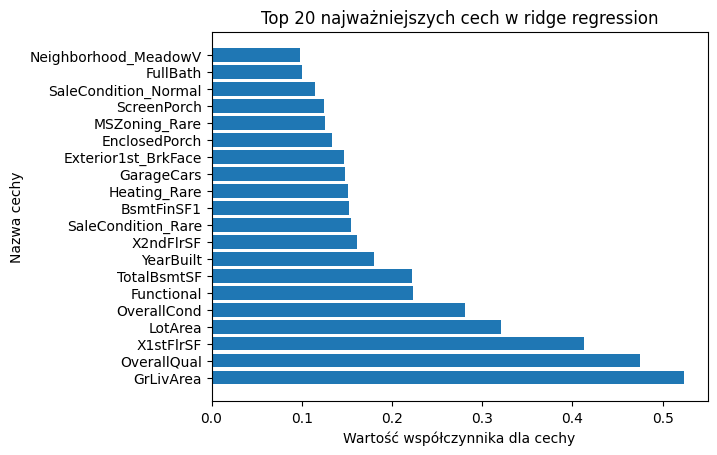

['LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'Utilities',
 'LandSlope',
 'MasVnrArea',
 'ExterCond',
 'BsmtCond',
 'BsmtUnfSF',
 'X1stFlrSF',
 'X2ndFlrSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'GarageQual',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'X3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MSSubClass_SC120',
 'MSSubClass_SC190',
 'MSSubClass_SC50',
 'MSSubClass_SC70',
 'MSSubClass_SC80',
 'MSSubClass_SC85',
 'LandContour_HLS',
 'LandContour_Low',
 'LotConfig_FR2',
 'LotConfig_Inside',
 'LotConfig_Rare',
 'Neighborhood_BrDale',
 'Neighborhood_Gilbert',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_Rare',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Timber',
 'Condition1_Feedr',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_Rare',
 'Condition2_Rare',
 'BldgType_2fmCon',
 'HouseStyle_1Story',
 'House

In [20]:
features = list(zip(reg_ridge_dense.feature_names_in_, reg_ridge_dense.coef_))
features.sort(key=lambda x: -np.abs(x[1]))
features_series = pd.Series([np.abs(coef) for _, coef in features], index=[name for name, _ in features])
plt.barh(features_series.index[:20], features_series[:20])
plt.title("Top 20 najważniejszych cech w ridge regression")
plt.ylabel("Nazwa cechy")
plt.xlabel("Wartość współczynnika dla cechy")
plt.show()

features2 = list(zip(reg_lasso_dense.feature_names_in_, reg_lasso_dense.coef_))
features2.sort(key=lambda x: np.abs(x[1]))
features2_series = pd.Series([coef for _, coef in features2], index=[name for name, _ in features2])
features2_series[np.isclose(features2_series, 0)].index.tolist()

## Robust regression

Powyższe algorytmy nie brały pod uwagę skośnego rozkładu zmiennej zależnej, oraz realnego zapotrzebowania na medianę ceny domu. Wypróbujmy zatem algorytmy, które powinny być bardziej odporne na outliery.

Na start wypróbujemy Least Absolute Deviations (LAD) regression. Jako że jest to przypadek szczególny regresji kwantylowej, to w Scikit-learn używa się do tego klasy `QuantileRegressor` z podaniem odpowiedniego kwantyla.

In [21]:
from sklearn.linear_model import QuantileRegressor

reg_lad = QuantileRegressor(quantile=0.5)
reg_lad.fit(X_train, y_train)

y_pred_train = reg_lad.predict(X_train)
y_pred_test = reg_lad.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train, y_pred_test)

Train RMSE 80520.69, MAE: 55705.73
Test  RMSE 80920.80, MAE: 55734.18


Błąd jest wręcz tragiczny! W takich przypadkach zawsze na start trzeba się przyjrzeć predykcjom.

In [22]:
y_pred_test[:30]

array([11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779,
       11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779,
       11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779,
       11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779,
       11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779,
       11.99535779, 11.99535779, 11.99535779, 11.99535779, 11.99535779])

Predykcje stałe - nic dziwnego, że błąd jest duży. Scikit-learn domyślnie stosuje lekką regularyzację dla wielu modeli, ale wartość ta może być zbyt duża.

**Zadanie 8 (1 punkt)**

Dokonaj tuningu siły regularyzacji dla LAD regression, sprawdzając 100 wartości z zakresu od 0 do `1e-3`. Wybierz model o najlepszym MAE z pomocą 5-fold CV. Zmierz czas tuningu, wypisz znalezione hiperparametry oraz sprawdź jakość finalnego modelu.

Skomentuj różnicę czasową i jakościową względem modeli ridge i LASSO. Czy w tym przypadku warto wykorzystać regresję LAD?

Przyda się `GridSearchCV` oraz parametr `n_jobs`.

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': np.linspace(0, 1e-3, num=100)}
start = time.time()
gs = GridSearchCV(QuantileRegressor(quantile=0.5), parameters, n_jobs=-1, verbose=4, scoring="neg_mean_absolute_error")
gs.fit(X_train, y_train)
end = time.time()
print(f"Execution Time for LAD using 5-fold CV: {end - start:.4f} seconds")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Execution Time for LAD using 5-fold CV: 1785.8163 seconds


In [24]:
reg_lad_cv = QuantileRegressor(quantile=0.5, alpha=gs.best_params_["alpha"])
reg_lad_cv.fit(X_train, y_train)

y_pred_train = reg_lad_cv.predict(X_train)
y_pred_test = reg_lad_cv.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train, y_pred_test)

Train RMSE 18170.97, MAE: 11649.58
Test  RMSE 18189.07, MAE: 12371.05


W porównaniu do domyślnych wartości parametru błąd zmalał znacząco, natomiast różnica jakościowa względem ridge i lasso jest znikoma. Jednakże czas potrzebny do znalezenia odpowiednich hiperparametrów i wytrenowania modelu jest znacząco gorszych od wspomnianych wcześniej modeli.

Zamiast używać regresji LAD, opartej o programowanie liniowe, można też wykorzystać Huber regression. Jest ono mało czuła zarówno na $\epsilon$ (punkt przejścia z MSE do MAE), jak i $\alpha$ (siłę regularyzacji L2), więc często nie wymaga tuningu hiperparametrów.

**Zadanie 9 (0.5 punktu)**

Wytrenuj model Huber regression. Sprawdź jakość modelu. Skomentuj różnicę czasową i jakościową względem LAD regression (tutaj oczywiście bez tuningu). Z którego modelu skorzystałbyś w praktyce?

Domyślna liczba iteracji solwera, 100, jest zbyt mała dla naszej liczby cech, i będą z tego wynikać ostrzeżenia o braku zbieżności, więc zwiększ ją do 2000.

In [25]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(max_iter=2000)
huber.fit(X_train, y_train)

y_pred_train = huber.predict(X_train)
y_pred_test = huber.predict(X_test)
evaluate_model(y_train, y_test, y_pred_train, y_pred_test)

Train RMSE 18584.63, MAE: 11701.18
Test  RMSE 17988.23, MAE: 12246.93


Zarówno różnica czasowa jak i jakościowa jest na + względem Huber regression. W praktyce pewnie skorzystałbym z modelu Huber, ale i tak porównanie wymagałoby przeliczenia obydwu modeli (chyba, że z doświadczenia wiedziałbym który będzie lepszy)

## Use case, połączenie w system end-to-end

Na rynku działa firma oferująca serwis do sprzedaży nieruchomości. CEO był na prezentacji o AI, zaczął używać ChatGPT i uznał, że też musicie mieć taki potężny ML. Zostałeś zatrudniony jako (pierwszy i jedyny) data scientist, zebrałeś historyczne dane, i nawet wdrożyłeś pierwszy model regresji liniowej do estymacji wartości nieruchomości.

Pewnego dnia Product Owner przychodzi do ciebie z listą "absolutnie krytycznych" wymagań (propozycja nie do odrzucenia):
1. Ciągle coś się sypie na produkcji, bo obecny pipeline do przetwarzania cech jest złożony z wielu kroków, które są copy-paste z twojego Jupyter Notebooka. Trzeba z tego zrobić jeden obiekt, zapisywać i wdrażać end-to-end.
2. Nowe domy czasem mają ekstremalne wartości cech, których nie było w zbiorze treningowym, i na tych przypadkach model radzi sobie wystarczająco słabo. Może wystarczyłoby je jakoś przyciąć?
3. Obecny model regresji liniowej działa w miarę ok, ale trzeba czegoś lepszego, co dawałoby lepsze MAE, bo większość klientów jest zainteresowana przeciętnie drogimi nieruchomościami.
4. Sama przewidywana wartość nieruchomości to za mało, bo każdy wie, że ceny są zróżnicowane. Twoja regresja liniowa podaje tylko warunkową średnią, a zarówno sprzedający, jak i kupujący chcieliby znać sensowne górne i dolne widełki. Product Owner ze swojego doświadczenia sugeruje, że typowo takie wahania różnią się co najwyżej o 15 punktów procentowych w górę i dół od średniej ceny.

**Zadanie 10 (4 punkty)**

1. Połącz wszystkie wcześniejsze transformery dla zmiennych numerycznych i kategorycznych w jeden duży `ColumnTransformer`. Ma do niego wejść cale `X_train_raw`, a wyjść gotowy output.
2. Przycinanie wartości do zakresu znanego ze zbioru treningowego nazywa się czasem **winsoryzacją (winsorization)**. Dodaj taki etap po skalowaniu min-max, a przed selekcją według korelacji. Przydatny będzie tutaj Feature-engine.
3. Na podstawie wcześniejszych eksperymentów wybierz model do przewidywania własności domów. Wybór uzasadnij w komentarzu. W razie potrzeby dokonaj tuningu hiperparametrów. Zmierz jakość modelu.
4. Wybierz i wytrenuj odpowiednie modele do regresji, żeby dostać estymację 35% i 65% ceny, w dodatku do przeciętnej ceny (estymowanej przez model z poprzedniego punktu). Dokonaj w razie potrzeby tuningu hiperparametrów. Metryką jakości może być tutaj [D^2 pinball score](d2_pinball_score), który ma wygodny zakres wartości $[0, 1]$ (dla dobrych modeli, im bliżej 1, tym lepiej). Podaj jakość finalnych modeli.
5. Zapisz transformer do preprocessingu oraz estymatory do regresji do plików [z pomocą Jobliba](https://scikit-learn.org/stable/model_persistence.html): `ames_transformer.joblib`, `price_estimator.joblib`, `low_price_estimator.joblib`, `high_price_estimator.joblib`.

Poniżej przygotowano funkcję testową, która ładuje transformer i estymatory, oraz oblicza predykcje dla trzech przykładowych domów ze zbioru testowego (taniego, przeciętnego i drogiego).

Skomentuj - czy twoim zdaniem finalne modele, podające przeciętną wartość i widełki, są subiektywnie dobrej jakości?

In [26]:
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import Ridge

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('winsorizer', Winsorizer()),
    ('feature selector', SmartCorrelatedSelection(threshold=0.8, selection_method="variance"))
])

cat_pipeline = Pipeline([
    ('rle', RareLabelEncoder(n_categories=0, tol=0.01)),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])


full_ct = ColumnTransformer([
    ('numerical pipeline', num_pipeline, numerical_features),
    ('categorical_pipeline', cat_pipeline, categorical_features)
], verbose_feature_names_out=False)

X_train0 = full_ct.fit_transform(X_train_raw)
X_test0 = full_ct.transform(X_test_raw)

model = QuantileRegressor(quantile=0.5, alpha=1e-3)
model.fit(X_train0, y_train)
y_pred_train = model.predict(X_train0)
y_pred_test = model.predict(X_test0)
evaluate_model(y_train, y_test, y_pred_train, y_pred_test)

Train RMSE 19111.24, MAE: 12097.96
Test  RMSE 18412.39, MAE: 12527.84


In [27]:
from sklearn.metrics import d2_pinball_score

qr35 = QuantileRegressor(quantile=0.35, alpha=1e-3)
qr35.fit(X_train0, y_train)
print(f"score for 35 quantile: {d2_pinball_score(y_test, qr35.predict(X_test0), alpha=0.35)}")
qr65 = QuantileRegressor(quantile=0.65, alpha=1e-3)
qr65.fit(X_train0, y_train)
print(f"score for 65 quantile: {d2_pinball_score(y_test, qr65.predict(X_test0), alpha=0.65)}")

score for 35 quantile: 0.7539058164722288
score for 65 quantile: 0.7784939496703858


In [28]:
import joblib


def test_models() -> None:
    transformer = joblib.load("ames_transformer.joblib")
    price_reg = joblib.load("price_estimator.joblib")
    low_price_reg = joblib.load("low_price_estimator.joblib")
    high_price_reg = joblib.load("high_price_estimator.joblib")

    # select houses from test set around 25th, 50th and 75th percentile
    prices = np.expm1(y_test).astype(int)

    for price_type, quantile in [
        ("Cheap", 0.25),
        ("Average", 0.5),
        ("Expensive", 0.75),
    ]:
        idx = prices[
            prices == prices.quantile(quantile, interpolation="nearest")
        ].index[0]
        X = X_test_raw.loc[idx].to_frame().T
        y = prices[idx]

        float_to_int = lambda x: int(np.round(np.expm1(x.item())))

        X_transformed = transformer.transform(X)
        y_pred = float_to_int(price_reg.predict(X_transformed))
        y_low_pred = float_to_int(low_price_reg.predict(X_transformed))
        y_high_pred = float_to_int(high_price_reg.predict(X_transformed))

        print(f"{price_type} house")
        print(f"True price: {y}$")
        print(f"Estimated price: {y_pred}")
        print(f"Price brackets: {y_low_pred} - {y_high_pred}")

        print("Features:")
        with pd.option_context("display.max_columns", None):
            display(X)

joblib.dump(full_ct, "ames_transformer.joblib")
joblib.dump(model, "price_estimator.joblib")
joblib.dump(qr35, "low_price_estimator.joblib")
joblib.dump(qr65, "high_price_estimator.joblib")


test_models()

Cheap house
True price: 127999$
Estimated price: 133634
Price brackets: 127888 - 139278
Features:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
195,SC50,RM,50.0,6000,2,0,4,Lvl,4,Inside,3,BrkSide,Norm,Norm,1Fam,1.5Fin,6,6,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,CBlock,3,3,0,2,264.0,1,0.0,308.0,572.0,GasA,5,Y,FuseA,848,348,0,1196,0.0,1.0,1,1,3,1,3,6,8,2,4,Detchd,1973.0,Unf,2.0,576.0,3,3,2,0,0,0,0,0,0,0,No,No,0,Mar,2010,WD,Normal


Average house
True price: 157999$
Estimated price: 151826
Price brackets: 145791 - 153611
Features:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2538,SC80,RL,80.0,9600,2,0,4,Lvl,4,Inside,3,NAmes,Norm,Norm,1Fam,SLvl,5,7,1967,1967,Gable,CompShg,MetalSd,MetalSd,BrkFace,140.0,3,3,PConc,3,3,2,5,602.0,3,402.0,137.0,1141.0,GasA,4,Y,SBrkr,1141,0,0,1141,1.0,0.0,1,0,3,1,3,6,8,0,0,Attchd,1967.0,Unf,1.0,568.0,3,3,2,0,78,0,0,0,0,0,No,No,0,Jul,2006,WD,Normal


Expensive house
True price: 209499$
Estimated price: 194443
Price brackets: 186064 - 203130
Features:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,X1stFlrSF,X2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
192,SC75,RL,0.0,7793,2,0,3,Bnk,4,Corner,3,BrkSide,Norm,Norm,1Fam,2.5Unf,7,7,1922,2005,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,BrkTil,4,3,0,4,474.0,1,0.0,634.0,1108.0,GasA,3,N,FuseA,1160,908,0,2068,0.0,0.0,1,1,3,1,4,8,8,1,4,Detchd,1928.0,Unf,1.0,315.0,3,3,2,0,0,60,0,0,0,0,No,No,0,May,2010,WD,Normal


Wybrałem regresje quantile z kwantylem 0.5, bo miała najmniejszą wartość MAE, a naszemu klientowi zależy właśnie na modelu który jak najlepiej minimalizuje ów błąd. Subiektywnie modele radzą sobie dość dobrze, szczególnie widełki dla klienta byłyby naprawdę wartościowymi informacjami.

## Zadanie dodatkowe (3 punkty)

Product Owner przychodzi do ciebie ponownie. Klienci skarżą się, że nie rozumieją, czemu model przewiduje taką, a nie inną wartość dla ich domu. Przykładowo, jeżeli to ogólny stan domu (`OverallCond`) czy garażu (`GarageCond`) obniżają cenę, to byliby gotowi je wyremontować dla lepszego zysku.

Jest to problem **wyjaśnialnego AI (Explainable AI, XAI)**. O ile cały model w przypadku regresji liniowej jest bardzo transparentny dzięki wagom cech i liniowym predykcjom, to już zrozumienie, czemu dana predykcja była taka, a nie inna, to już problem **lokalnej wyjaśnialności (local explainability)**, gdzie tłumaczymy pojedynczą predykcję, dla danego zestawu cech.

Najpopularniejszym algorytmem jest tutaj **SHapley Additive Explanations (SHAP)**. Opiera się on o tzw. wartości Shapleya, mające bardzo solidne podstawy w kooperatywnej teorii gier. Opiera się na idei, że wartości cech grają w grę: jedne obniżają predykcję, a drugie podwyższają, a finalna predykcja modelu to ich konsekwencja. Każda cecha to gracz, ale jedna wnosi więcej, a inna mniej. Idea algorytmu SHAP to uznanie, że "wartościowi gracze" to wpływowe cechy, które mocno przyczyniły się do danej decyzji modelu.

Obliczanie wartości Shapleya w ogólnym przypadku ma złożoność eksponencjalną. Algorytm SHAP zaproponował efektywne ich przybliżanie dla dowolnych algorytmów ML. Dla niektórych klas modeli, przede wszystkim liniowych oraz drzewiastych, istnieją szczególnie efektywne metody, które w czasie wielomianowym obliczają dokładne wartości Shapleya. Wyjaśnienia, jak działa SHAP: [link 1](https://www.youtube.com/watch?v=9haIOplEIGM), [link 2](https://www.youtube.com/watch?v=VB9uV-x0gtg), [link 3](https://www.youtube.com/watch?v=0yXtdkIL3Xk).

Z pomocą biblioteki `shap` oblicz wartości Shapleya dla przykładowych domów z ostatniego zadania i wyświetl je na tzw. force plot. Przyda ci się tutaj `LinearExplainer` ([dokumentacja](https://shap.readthedocs.io/en/latest/generated/shap.LinearExplainer.html#shap.LinearExplainer)) oraz `plots.force()` ([dokumentacja](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html)).

Porównaj ze sobą dwie metody estymacji: "interventional" oraz "correlation_dependent" (opisane w dokumentacji). Możesz je zaimplementować za pomocą `maskers.Independent` oraz `maskers.Impute`. Jako zbiór do porównania (tzw. background samples) użyj całego zbioru treningowego.

Skomentuj, czy wyjaśnienia mają twoim zdaniem sens i czy są intuicyjne. Która metoda estymacji daje subiektywnie lepsze wyniki?